In [14]:
from pprint import pprint

In [1]:
from langgraph.graph import StateGraph, MessagesState, START, END

def mock_llm(state: MessagesState):
    return {"messages": [{"role": "ai", "content": "hello world"}]}

graph = StateGraph(MessagesState)
graph.add_node(mock_llm)
graph.add_edge(START, "mock_llm")
graph.add_edge("mock_llm", END)
graph = graph.compile()

graph.invoke({"messages": [{"role": "user", "content": "hi!"}]})

{'messages': [HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='6c0746dc-9dfe-4c8f-9c77-e232d086da45'),
  AIMessage(content='hello world', additional_kwargs={}, response_metadata={}, id='bcd24c09-c18a-4063-8928-93eb74a9f290')]}

- Graph API: node와 edge를 이용하여 graph 형태로 Agent를 생성한다.
- Functional API: 단일 fucntion으로의 Agent를 생성한다.

In [2]:
model_name = "gpt-5.1"

In [3]:
from langchain.tools import tool
from langchain.chat_models import init_chat_model


model = init_chat_model(
    model=model_name,
    temperature=0
)


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

In [15]:
pprint(model_with_tools.get_graph())

Graph(nodes={'389735806a3949eb8ec5492502905be9': Node(id='389735806a3949eb8ec5492502905be9', name='ChatOpenAI', data=ChatOpenAI(profile={'max_input_tokens': 400000, 'max_output_tokens': 128000, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x1161b6870>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x115d0fe00>, root_client=<openai.OpenAI object at 0x1160bc500>, root_async_client=<openai.AsyncOpenAI object at 0x116f68620>, model_name='gpt-5.1', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True), metadata={}),
             'a7a1cdc974854142a8f25c773c476a60': Node(id='a7a1cdc974854142a8f25

In [ ]:
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator


# graph의 state는 대화 내역이나 LLM 호출 횟수 등을 저장하는 용도로 사용된다.
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]  # operator.add와 함께 사용되는 Annotated는 대화 내역을 대체하는 게 아닌, 새로운 대화 내역을 추가할 수 있도록 해준다.
    llm_calls: int

- Annotated란?
    - 타입 힌트에 추가 메타데이터를 붙이기 위한 표준 도구. 문서 생성이나 UI 힌트 등에 활용 가능.
    - 예시
        ```
        from typing_extensions import Annotated

        Age = Annotated[int, "나이는 0 이상 100 이하"]
        ```
        - int는 타입 체크용으로 실제 타입에 해당
        - "나이는 0 이상 100 이하"는 추가 메타데이터
- operator.add란?
    - 두 개의 값을 더하는 연산자. 이 연산자는 두 개의 값을 더하는 연산을 수행하는 함수를 반환한다.
    - 예시
        ```
        from operator import add

        add(1, 2)  # 3
        ```

In [ ]:
from langchain.messages import SystemMessage


def llm_call(state: dict):
    """LLM은 tool을 호출할지 말지 결정한다."""

    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]  # 시스템 프롬프트에 대화 내역을 추가
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1  # 호출 횟수 1개 증가
    }

In [ ]:
from langchain.messages import ToolMessage


def tool_node(state: dict):
    """tool 호출 후 결과를 반환한다."""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]  # tool_name을 이용하여 사전에 정의된 tool을 가져온다.
        observation = tool.invoke(tool_call["args"])  # tool을 호출하고 결과를 반환한다.
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))  # tool 호출 결과를 메시지로 변환하여 결과 목록에 추가한다.
    return {"messages": result}

In [ ]:
from typing import Literal
from langgraph.graph import StateGraph, START, END


def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """LLM이 tool 호출을 했는지 여부에 따라 다음 노드를 결정한다."""

    messages = state["messages"]
    last_message = messages[-1]

    # LLM이 tool 호출을 만들었으면 tool_node로 이동하도록 "tool_node" 반환
    if last_message.tool_calls:
        return "tool_node"

    # 그렇지 않으면 대화를 종료하도록 END 반환
    return END

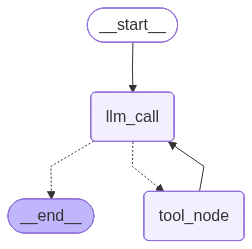

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_SnE50UQ8bYcESJHJF8xa6VX4)
 Call ID: call_SnE50UQ8bYcESJHJF8xa6VX4
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

3 + 4 = 7


In [ ]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)  # llm_call 노드 추가
agent_builder.add_node("tool_node", tool_node)  # tool_node 노드 추가

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")  # START에서 llm_call 노드로 이동
agent_builder.add_conditional_edges(  # llm_call 노드에서 should_continue 함수를 호출하여 'tool_node' 또는 'END' 노드로 이동하도록 지정
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")  # tool_node 노드에서 llm_call 노드로 이동

# Compile the agent
agent = agent_builder.compile()  # compile 메서드는 graph를 compiled graph로 반환한다. compiled graph는 Runnable 인터페이스로 구현되어 있어, 'invoke', 'batch', 'astream' 등의 메서드를 사용할 수 있다.

# Show the agent
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
from langchain.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})  # message state를 인자로 받아, 대화 내역을 업데이트한다.
for m in messages["messages"]:
    m.pretty_print()